## Course: TM10007 - Machine learning
Editors: Lishia Vergeer, Amy Roos, Maaike Pruijt, Hilde Roording.

Description: The aim of this code is to predict the tumor grade of glioma’s (high or low), 
based on features extracted from a combination of four MRI images: 
T2-weighted, T2-weighted FLAIR and T1-weighted before and after injection of contrast agent.

#### Import packages

In [8]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Import code
from brats.load_data import load_data

# Split
from sklearn.model_selection import train_test_split

# scaler
from sklearn.preprocessing import MinMaxScaler 

# gridsearch
from sklearn.model_selection import RandomizedSearchCV

#Machine learning classifiers
from sklearn import decomposition, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold


#### Load data
load data with given function load_data.py by creating a dataframe from de CSV file called data_brats.csv. The number of samples and features is printed below.

In [9]:
data_brats = load_data()

# Convert to dataframe
X = pd.DataFrame(data_brats)

# Print data 
print(f'The number of samples in data_brats: {len(X.index)}')
print(f'The number of columns in data_brats: {len(X.columns)}')

The number of samples in data_brats: 167
The number of columns in data_brats: 725


c:\Users\Lishia\Documents\Jaar_1\TM10007 - Machine Learning\Repositories\TM10007\brats\load_data.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(data2)


#### Split data in X (data) and y (label)
The data contains the features as well as a column with the label that needs to be predicted. In this section this label is splitted from the dataframe in X (data) and y (label). Also the textual labels are converted to binary numbers to be easily processed.

In [10]:
# split column label from dataset X
y = X.pop('label')

# replace 'GBM' and 'LGG' with 1 and 0 respectively
y = y.replace(['GBM'], 1)
y = y.replace(['LGG'], 0)

#### Split data in train and test set
This section splits the data into two data frames, a test and a train data frame with the train_test_split from the sklearn module.
This returns a train set with the data of 80% and a test set of 20% of the subjects.

In [11]:
# Split data in train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)  

#### Divergent values to NaN
In this section non-numeric values as 'infinity' and '#DIV/0' values in both of the data frames are replaced by 'NaN' values.

In [12]:
# infinity to NaN
X_train[X_train==np.inf]=np.nan
X_test[X_test==np.inf]=np.nan

# non-numeric features to NaN
X_train = X_train.replace(['#DIV/0!'], np.nan)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

X_test  = X_test.replace(['#DIV/0!'], np.nan)
X_test = X_test.apply(pd.to_numeric, errors='coerce')

#### Visualising outliers
In this section below the outliers and missing values of the training data frame are visualized.

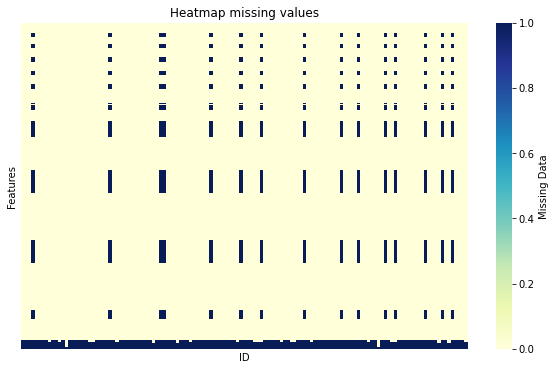

In [13]:
plt.figure(figsize=(10,6))
sb.heatmap(X_train.isna().transpose(),
            yticklabels=False, xticklabels=False, 
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)
plt.title('Heatmap missing values')
plt.ylabel('Features')
plt.xlabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap.png", dpi=100)

#### Outliers to NaN
In the section below the outliers of the training data frame are converted to 'NaN' values



In [14]:
for column in X_train:
    # Removing outliers
    q1 = X_train[column].quantile(0.25)
    q3 = X_train[column].quantile(0.75)
    iqr = q3-q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Information outliers
    outliers = [x for x in X_train[column] if x < lower or x > upper]
    outliers_removed = [x for x in X_train[column] if x >= lower and x <= upper]

    X_train[column].loc[X_train[column] > upper] = np.nan
    X_train[column].loc[X_train[column] < lower] = np.nan

C:\Users\Lishia\AppData\Local\Temp\ipykernel_13960\1660104299.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column].loc[X_train[column] > upper] = np.nan


#### Visualising missing data after removing outliers
In the section below the training data frame is visualized after the removal of outliers.

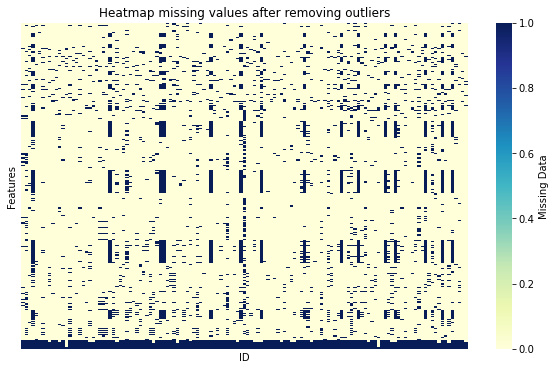

In [15]:
plt.figure(figsize=(10,6))
sb.heatmap(X_train.isna().transpose(),
            yticklabels=False, xticklabels=False, 
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)
plt.title('Heatmap missing values after removing outliers')
plt.ylabel('Features')
plt.xlabel('ID')
plt.savefig("visualizing_missing_data_with_heatmap_outliers.png", dpi=100)

#### Drop columns
In the section below all features that contain more than 40% NaN values in de training data frame are dropped from the data frame. The same features are also dropped from the test data frame.

In [16]:
# If the total number of NaN observations in a column are greater than 40%, delete the entire column.
perc = 40.0
min_count = int(((100-perc)/100)*X_train.shape[0] + 1)
X_train_drop = X_train.dropna(axis=1, thresh=min_count)
X_labels = X_train_drop.keys()

X_test_drop = X_test[X_labels]

#### Fill the NaN observations.

In the section below all remaining NaN values are replaced by the mean of the values from the corresponding feature.


In [17]:
data_fill_train = X_train_drop.fillna(X_train_drop.mean()) 
data_fill_test = X_test_drop.fillna(X_test_drop.mean()) 

#### Scale features
In the section below the training data as well as the test data is normalized by the use of the MinMaxScaler().

In [18]:
# Scaler
scaler = MinMaxScaler()
scaler.fit(data_fill_train)
X_train_scaled = scaler.transform(data_fill_train)
X_test_scaled = scaler.transform(data_fill_test)

#### Transform features
To create a dataframe with usefull features to train the classifier, a principe component analysis (PCA) is performed.

In [19]:
# Perform a PCA
pca = decomposition.PCA(n_components=5)
pca.fit(X_train_scaled) 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### Cross validation
In the section below the cross validation score of three classifiers is calculated, based on which the best classifier can be selected for the data.

In [20]:
# Create a cross-validation object
cv = KFold(n_splits=5, shuffle= True, random_state = 1)

X = X_train_pca

y = y_train.values
y = y.tolist()

classifiers = (KNeighborsClassifier(), RandomForestClassifier(), SVC())
scores = ['accuracy', 'recall', 'roc_auc']

score_list = []
for cls in classifiers:
    score_dict = {'Classifier':[cls]}
    score_list.append(score_dict)
    for score in scores:
        list_scores = cross_val_score(cls, X, y, scoring = score , cv=cv)
        mean = np.mean(list_scores)
        score_dict ={score: [mean]}
        score_list.append(score_dict)
        
dict1 = score_list[0] | score_list[1] | score_list[2] | score_list[3]
dict2 = score_list[4] | score_list[5] | score_list[6] | score_list[7]
dict3 = score_list[8] | score_list[9] | score_list[10] | score_list[11]

score_frame1 = pd.DataFrame(dict1)
score_frame2 = pd.DataFrame(dict2)
score_frame3 = pd.DataFrame(dict3)
frames = [score_frame1, score_frame2, score_frame3]
score_frame = pd.concat(frames)
print(score_frame)


                 Classifier  accuracy    recall   roc_auc
0    KNeighborsClassifier()  0.856980  0.913831  0.883338
0  RandomForestClassifier()  0.842165  0.905714  0.910201
0                     SVC()  0.849288  0.923831  0.897025


#### Support Vector Machine hyper parameter search 
In the section below the optimal settings for the selected classifier (SVM) are calculated.


In [21]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma' : [1, 0.1, 0.01, 0.001],
    'kernel' : ['linear']
}

svm_model = SVC(gamma='auto')

svm_grid = RandomizedSearchCV(estimator = svm_model, param_distributions = param_grid, cv = 3, verbose = 2, n_jobs =4)
svm_grid.fit(X_train_pca, y_train)

best_param = svm_grid.best_params_
best_estimator = svm_grid.best_estimator_

print(f'The best parameters are : {best_param}')
print(f'The best estimators are : {best_estimator}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
The best parameters are : {'kernel': 'linear', 'gamma': 0.1, 'C': 10}
The best estimators are : SVC(C=10, gamma=0.1, kernel='linear')


#### Performance SVM
In the section below the performance of the SVM classifier used for the test set is calculated.

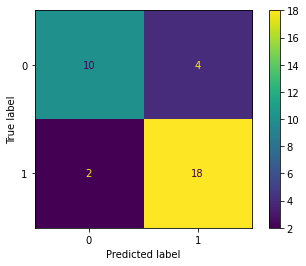

   accuracy  sensitivity  specificity
0  0.823529          0.9     0.714286
Test accuracy train set is:0.895
Test accuracy test set is: 0.824


In [22]:
pred = svm_grid.predict(X_test_pca)
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

classifier = 'SVM'
accuracy = metrics.accuracy_score(y_test, pred)
sensitivity = metrics.recall_score(y_test, pred, pos_label=1)
specificity = metrics.recall_score(y_test, pred, pos_label=0)

dict_test = {'accuracy': [accuracy], 'sensitivity': [sensitivity], 'specificity': [specificity]}
performance = pd.DataFrame(dict_test)

print(performance)
print(f'Test accuracy train set is:{svm_grid.score(X_train_pca, y_train):.3f}')
print (f'Test accuracy test set is: {svm_grid.score(X_test_pca, y_test):.3f}')